# 02 - Modelos de referencia (_Baselines_)  

Este cuaderno establece el **rendimiento base** (*benchmarking*) del proyecto mediante la evaluación de tres modelos de referencia. El objetivo es obtener métricas de error (RMSE, MAE, $R^2$) que sirvan como punto de comparación para validar la mejora aportada por el modelo híbrido propuesto posteriormente.  

Se evalúan los siguientes modelos sobre el conjunto de test:
1.  **Baseline A (Simulación física):** La irradiancia calculada directamente por el complemento de software de Unreal Engine, tras aplicar la calibración radiométrica (Ineichen-Perez). Representa la capacidad del motor geométrico por sí mismo.
2.  **Baseline B (Clear-sky):** Modelo teórico de cielo despejado. Sirve para entender el error máximo en días nublados y como referencia superior.
3.  **Baseline C (XGBoost Meteo):** Un modelo de *Machine Learning* entrenado exclusivamente con variables meteorológicas (*cloud_opacity*, *precipitable_water*, etc.) y variables físicas reales de referencia (azimut, elevación), sin información geométrica del motor. Sirve para evaluar la aportación del motor al modelo híbrido.

## 1. Importación de librerías

In [1]:
import os
import json
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

## 2. Configuración de los modelos de referencia

In [2]:
CFG = {
    "data_path": "../data/dataset_master_tfg.csv",
    "out_dir": "../artifacts",
    "test_dates": ["2025-04-11", "2025-04-20", "2025-10-07"],

    # Training filters
    "train_filter": {"min_altitude_deg": 5.0},

    # Key columns
    "cols": {
        "date": "date",
        "sensor": "sensor",
        "y": "real_irradiance",
        "baseline_a_col": "sim_irradiance_wm2",
        "baseline_b_col": "sim_cs_ghi",
        "utc": None,
    },

    # Features for Model C (XGBoost Meteo)
    "meteo_features": [
        "cloud_opacity",
        "zenith",
        "precipitable_water",
        "azimuth",
    ],
    "use_sensor_dummies": True,

    # XGBoost hyperparameters
    "xgb_params": dict(
        n_estimators=800,
        learning_rate=0.01,
        max_depth=5,
        min_child_weight=60,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=4.0,
        gamma=0.0,
        objective="reg:squarederror",
        eval_metric="rmse",
        random_state=42,
        n_jobs=-1
    ),

    "export_preds": True,

    # Reporting / plots
    "report": {
        "lang": "es",
        "labels": {
            "date": "Fecha",
            "model": "Modelo",
            "daily_comparison_title": "Comparativa diaria por modelo — {metric}",
        },
        "model_labels": {
            "A_Physical_Simulation": "Baseline A — Normalización",
            "B_ClearSky": "Baseline B — Cielo despejado",
            "C_XGBoost_Meteo": "Baseline C — XGBoost (Meteo)",
        },  
        "dpi": 300,
        "figsize": (10, 5),
        "font_size": 11,
        "title_size": 12,
        "label_size": 11,
        "tick_size": 10,
        "legend_size": 10,
        "grid_alpha": 0.25,
        "line_width": 1.6,
        "bar_width": 0.82,
        "palette": [ 
            "#1F4E79",  
            "#4F81BD",  
            "#8FAADC",  
            "#A6A6A6",  
        ],
        "export_formats": ["png", "pdf"],
    }
}

os.makedirs(CFG["out_dir"], exist_ok=True)

## 3. Funciones

### 3.1 Funciones de métricas y reporte

In [3]:
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Calcula un conjunto de métricas de regresión.
    Devuelve:
        r2, mae, rmse, mbe, mape_pct, nrmse_pct, n, y_mean, y_max
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    # Drop NaNs safely (both sides)
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    n = int(y_true.size)
    if n == 0:
        return {
            "r2": np.nan, "mae": np.nan, "rmse": np.nan, "mbe": np.nan,
            "mape_pct": np.nan, "nrmse_pct": np.nan,
            "n": 0, "y_mean": np.nan, "y_max": np.nan
        }

    # Core metrics
    r2 = r2_score(y_true, y_pred) if n > 1 else np.nan
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mbe = float(np.mean(y_pred - y_true))

    # Scale-aware metrics 
    eps = 1e-6
    denom = np.maximum(np.abs(y_true), eps)
    mape_pct = float(np.mean(np.abs((y_pred - y_true) / denom)) * 100.0)

    y_mean = float(np.mean(y_true))
    y_max = float(np.max(y_true))
    nrmse_pct = float((rmse / max(y_mean, eps)) * 100.0)  # RMSE normalized by mean

    return {
        "r2": float(r2),
        "mae": float(mae),
        "rmse": float(rmse),
        "mbe": float(mbe),
        "mape_pct": float(mape_pct),
        "nrmse_pct": float(nrmse_pct),
        "n": float(n),          # keep JSON-friendly
        "y_mean": float(y_mean),
        "y_max": float(y_max),
    }

In [4]:
def print_daily_results(results_list: List[Dict]) -> Tuple[Optional[pd.DataFrame], Optional[Dict[str, pd.DataFrame]]]:
    
    rows = []
    for res in results_list:
        model_name = res.get("model", "UNKNOWN")
        for day_metric in res.get("metrics_by_day", []):
            rows.append({
                "Date": day_metric.get("date"),
                "Model": model_name,
                "R2": day_metric.get("r2"),
                "MAE": day_metric.get("mae"),
                "RMSE": day_metric.get("rmse"),
                "MBE": day_metric.get("mbe"),
                "MAPE_%": day_metric.get("mape_pct"),
                "nRMSE_%": day_metric.get("nrmse_pct"),
                "N": day_metric.get("n"),
                "Y_mean": day_metric.get("y_mean"),
                "Y_max": day_metric.get("y_max"),
            })

    df_daily = pd.DataFrame(rows)
    if df_daily.empty:
        print("Warning: no hay datos diarios que mostrar.")
        return None, None

    # Ensure stable ordering
    df_daily["Date"] = pd.to_datetime(df_daily["Date"], errors="coerce").dt.strftime("%Y-%m-%d")
    df_daily = df_daily.sort_values(["Date", "Model"]).reset_index(drop=True)

    metrics_cols = ["RMSE", "MAE", "R2", "MBE", "MAPE_%", "nRMSE_%"]
    pivots: Dict[str, pd.DataFrame] = {}

    for m in metrics_cols:
        p = df_daily.pivot(index="Date", columns="Model", values=m)
        p.loc["MEAN"] = p.mean(numeric_only=True)
        pivots[m] = p

    # Console print
    print("\n" + "=" * 72)
    print("COMPARACION DIARIA")
    print("=" * 72)
    for m in ["RMSE", "MAE", "R2", "MBE"]:
        print(f"\nMetric: {m}")
        print(pivots[m].round(3))
    print("\n" + "=" * 72)

    return df_daily, pivots

In [5]:
def _configure_matplotlib(cfg: Dict) -> None:
    
    r = cfg["report"]
    plt.rcParams.update({
        "figure.dpi": r["dpi"],
        "savefig.dpi": r["dpi"],
        "font.size": r["font_size"],
        "axes.titlesize": r["title_size"],
        "axes.labelsize": r["label_size"],
        "xtick.labelsize": r["tick_size"],
        "ytick.labelsize": r["tick_size"],
        "legend.fontsize": r["legend_size"],
        "axes.grid": True,
        "grid.alpha": r["grid_alpha"],
        "grid.linestyle": "-",
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

In [6]:
def plot_daily_metric_bars(
    pivot: pd.DataFrame,
    metric_name: str,
    ylabel: str,
    cfg: Dict,
    filename_base: str,
    drop_mean: bool = True
) -> None:
    _configure_matplotlib(cfg)
    r = cfg["report"]

    labels = r.get("labels", {})
    model_labels = r.get("model_labels", {})

    data = pivot.copy()
    if drop_mean:
        data = data.drop(index="MEAN", errors="ignore")

    if data.empty:
        print(f"Warning: no hay datos para graficar {metric_name}.")
        return

    # Renombrar modelos para salida (figuras/leyenda)
    if model_labels:
        data = data.rename(columns=model_labels)

    # Paleta estable
    models = list(data.columns)
    palette = r["palette"]
    colors = [palette[i % len(palette)] for i in range(len(models))]

    ax = data.plot(
        kind="bar",
        figsize=r["figsize"],
        width=r["bar_width"],
        color=colors,
        edgecolor="black",
        linewidth=0.3
    )

    title_tpl = labels.get("daily_comparison_title", "Comparación diaria entre modelos — {metric}")
    ax.set_title(title_tpl.format(metric=metric_name))

    ax.set_ylabel(ylabel) 
    ax.set_xlabel(labels.get("date", "Date"))

    ax.tick_params(axis="x", rotation=45)
    ax.legend(title=labels.get("model", "Model"), frameon=True)

    ax.grid(axis="x", visible=False)
    ax.grid(axis="y", alpha=r["grid_alpha"])

    plt.tight_layout()

    out_dir = os.path.join(cfg["out_dir"], "figures")
    os.makedirs(out_dir, exist_ok=True)

    for fmt in r["export_formats"]:
        out_path = os.path.join(out_dir, f"{filename_base}.{fmt}")
        plt.savefig(out_path, bbox_inches="tight")

    plt.show()

### 3.2 Funciones de datos y modelo

In [7]:
def load_dataset(cfg: Dict) -> pd.DataFrame:
    df = pd.read_csv(cfg["data_path"])
    date_col = cfg["cols"]["date"]
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce").dt.strftime("%Y-%m-%d")
    if date_col in df.columns:
        df = df.sort_values(by=date_col)
    return df

In [8]:
def apply_filters(df: pd.DataFrame, cfg: Dict) -> pd.DataFrame:
    df = df.copy()

    # Min solar altitude filter (if available)
    min_alt = cfg["train_filter"].get("min_altitude_deg", None)
    if min_alt is not None and "sim_altitude" in df.columns:
        df = df[df["sim_altitude"] >= float(min_alt)]

    # Drop NaNs in target
    y_col = cfg["cols"]["y"]
    df = df.dropna(subset=[y_col])

    return df

In [9]:
def add_sensor_dummies(df: pd.DataFrame, cfg: Dict) -> pd.DataFrame:
    if not cfg.get("use_sensor_dummies", True):
        return df
    sensor_col = cfg["cols"]["sensor"]
    if sensor_col in df.columns:
        df = pd.get_dummies(df, columns=[sensor_col], prefix="sensor")
    return df

In [10]:
def split_train_test(df: pd.DataFrame, cfg: Dict) -> Tuple[pd.DataFrame, pd.DataFrame]:
    date_col = cfg["cols"]["date"]
    test_dates = set(cfg["test_dates"])
    test_df = df[df[date_col].isin(test_dates)].copy()
    train_df = df[~df[date_col].isin(test_dates)].copy()
    return train_df, test_df

In [11]:
def resolve_feature_list(df: pd.DataFrame, base_features: List[str], cfg: Dict) -> List[str]:
    feats = list(base_features)

    if cfg.get("use_sensor_dummies", True):
        sensor_cols = [c for c in df.columns if c.startswith("sensor_")]
        feats.extend([c for c in sensor_cols if c not in feats])

    final_feats = [f for f in feats if f in df.columns]
    missing = sorted(list(set(feats) - set(final_feats)))
    if missing:
        print(f"Warning: features no encontradas en el CSV y que serán ignoradas: {missing}")

    return final_feats

In [12]:
def prepare_xy(df: pd.DataFrame, features: List[str], cfg: Dict) -> Tuple[pd.DataFrame, np.ndarray]:
    y_col = cfg["cols"]["y"]
    X = df[features].copy()
    y = df[y_col].astype(float).values
    return X, y

In [13]:
def fit_xgb(train_df: pd.DataFrame, features: List[str], cfg: Dict) -> XGBRegressor:
    X, y = prepare_xy(train_df, features, cfg)
    model = XGBRegressor(**cfg["xgb_params"])
    model.fit(X, y)
    return model

In [14]:
def predict_xgb(model: XGBRegressor, df: pd.DataFrame, features: List[str]) -> np.ndarray:
    X = df[features].copy()
    pred = model.predict(X)
    return np.maximum(pred, 0.0)  # irradiance should not be negative

In [15]:
def evaluate_predictions(test_df: pd.DataFrame, y_pred: np.ndarray, cfg: Dict) -> Tuple[Dict, List[Dict]]:
    y_true = test_df[cfg["cols"]["y"]].astype(float).values
    m_global = compute_metrics(y_true, y_pred)

    date_col = cfg["cols"]["date"]
    rows_day: List[Dict] = []
    for d in sorted(test_df[date_col].unique()):
        mask = (test_df[date_col].values == d)
        if not np.any(mask):
            continue
        m = compute_metrics(y_true[mask], y_pred[mask])
        rows_day.append({"date": d, **m})

    return m_global, rows_day

In [16]:
def export_optional_preds(test_df: pd.DataFrame, y_pred: np.ndarray, model_name: str, cfg: Dict) -> None:
    if not cfg.get("export_preds", False):
        return

    out_dir = os.path.join(cfg["out_dir"], "predictions")
    os.makedirs(out_dir, exist_ok=True)

    date_col = cfg["cols"]["date"]
    df_temp = test_df.copy()
    df_temp["pred"] = y_pred

    for d in df_temp[date_col].unique():
        subset = df_temp[df_temp[date_col] == d]
        fpath = os.path.join(out_dir, f"preds_{model_name}_{d}.csv")
        subset.to_csv(fpath, index=False)

## 4. Ejecución

In [17]:
def run_baselines(cfg: Dict) -> Tuple[pd.DataFrame, List[Dict]]:
    print("Inicializando Baselines (A, B, C) ...")

    # Load / preprocess
    df = load_dataset(cfg)
    df = apply_filters(df, cfg)
    df = add_sensor_dummies(df, cfg)

    train_df, test_df = split_train_test(df, cfg)
    print(f"Datos cargados. Filas de entrenamiento: {len(train_df)} | Filas de test: {len(test_df)}")

    results: List[Dict] = []

    # -------------------------------------------------------------------------
    # A) Physical simulation baseline
    # -------------------------------------------------------------------------
    print("\nA) Simulación física normalizada")
    col_a = cfg["cols"]["baseline_a_col"]
    if col_a in test_df.columns:
        pred_a = test_df[col_a].astype(float).clip(lower=0.0).values
        m_glob, m_day = evaluate_predictions(test_df, pred_a, cfg)

        results.append({
            "model": "A_Physical_Simulation",
            "details": f"Direct column: {col_a}",
            "metrics_global": m_glob,
            "metrics_by_day": m_day,
        })
        export_optional_preds(test_df, pred_a, "A_Physical_Simulation", cfg)
    else:
        print(f"Error: column not found for Baseline A: {col_a}")

    # -------------------------------------------------------------------------
    # B) Clear-sky baseline
    # -------------------------------------------------------------------------
    print("\nB) Modelo Clear-Sky")
    col_b = cfg["cols"]["baseline_b_col"]
    if col_b in test_df.columns:
        pred_b = test_df[col_b].astype(float).clip(lower=0.0).values
        m_glob, m_day = evaluate_predictions(test_df, pred_b, cfg)

        results.append({
            "model": "B_ClearSky",
            "details": f"Direct column: {col_b}",
            "metrics_global": m_glob,
            "metrics_by_day": m_day,
        })
        export_optional_preds(test_df, pred_b, "B_clearsky", cfg)
    else:
        print(f"Error: column not found for Baseline B: {col_b}")

    # -------------------------------------------------------------------------
    # C) XGBoost Meteo baseline
    # -------------------------------------------------------------------------
    print("\nC) Modelo meteo XGBoost")
    feats_c = resolve_feature_list(train_df, cfg["meteo_features"], cfg)
    if feats_c:
        model_c = fit_xgb(train_df, feats_c, cfg)
        pred_c = predict_xgb(model_c, test_df, feats_c)
        m_glob, m_day = evaluate_predictions(test_df, pred_c, cfg)

        results.append({
            "model": "C_XGBoost_Meteo",
            "details": f"Features: {len(feats_c)} (meteo + sensor dummies)",
            "metrics_global": m_glob,
            "metrics_by_day": m_day,
        })
        export_optional_preds(test_df, pred_c, "C_XGBoost_Meteo", cfg)
    else:
        print("Error: no existen features con las que entrenar XGBoost.")

    # -------------------------------------------------------------------------
    # Summary tables
    # -------------------------------------------------------------------------
    flat_rows = []
    for r in results:
        mg = r["metrics_global"]
        flat_rows.append({
            "model": r["model"],
            "global_r2": mg["r2"],
            "global_rmse": mg["rmse"],
            "global_mae": mg["mae"],
            "global_mbe": mg["mbe"],
            "global_mape_pct": mg["mape_pct"],
            "global_nrmse_pct": mg["nrmse_pct"],
            "global_n": mg["n"],
            "details": r["details"],
        })

    df_out = pd.DataFrame(flat_rows).sort_values("global_rmse", ascending=True)

    # Persist outputs
    df_out.to_csv(os.path.join(cfg["out_dir"], "baselines_summary.csv"), index=False)

    def convert_default(obj):
        if isinstance(obj, (np.integer,)):
            return int(obj)
        if isinstance(obj, (np.floating,)):
            return float(obj)
        return str(obj)

    with open(os.path.join(cfg["out_dir"], "baselines_detailed.json"), "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, default=convert_default)

    print("\nEjecución de modelos de referencia completada.")
    return df_out, results

<>:5: SyntaxWarning: invalid escape sequence '\C'
<>:5: SyntaxWarning: invalid escape sequence '\C'
C:\Users\victo\AppData\Local\Temp\ipykernel_6160\3923922674.py:5: SyntaxWarning: invalid escape sequence '\C'
  print("\COMPARATIVA GLOBAL")


Inicializando Baselines (A, B, C) ...
Datos cargados. Filas de entrenamiento: 12028 | Filas de test: 4208

A) Simulación física normalizada

B) Modelo Clear-Sky

C) Modelo meteo XGBoost

Ejecución de modelos de referencia completada.
\COMPARATIVA GLOBAL
                   model  global_r2  global_rmse  global_mae  global_mbe
2        C_XGBoost_Meteo      0.711      157.136     105.014     -14.686
1             B_ClearSky      0.086      279.524     198.993     119.693
0  A_Physical_Simulation     -0.113      308.329     212.943     157.413

COMPARACION DIARIA

Metric: RMSE
Model       A_Physical_Simulation  B_ClearSky  C_XGBoost_Meteo
Date                                                          
2025-04-11                447.395     404.115          143.257
2025-04-20                267.374     227.953          201.636
2025-10-07                 44.154     105.131          102.669
MEAN                      252.974     245.733          149.187

Metric: MAE
Model       A_Physical_Simula

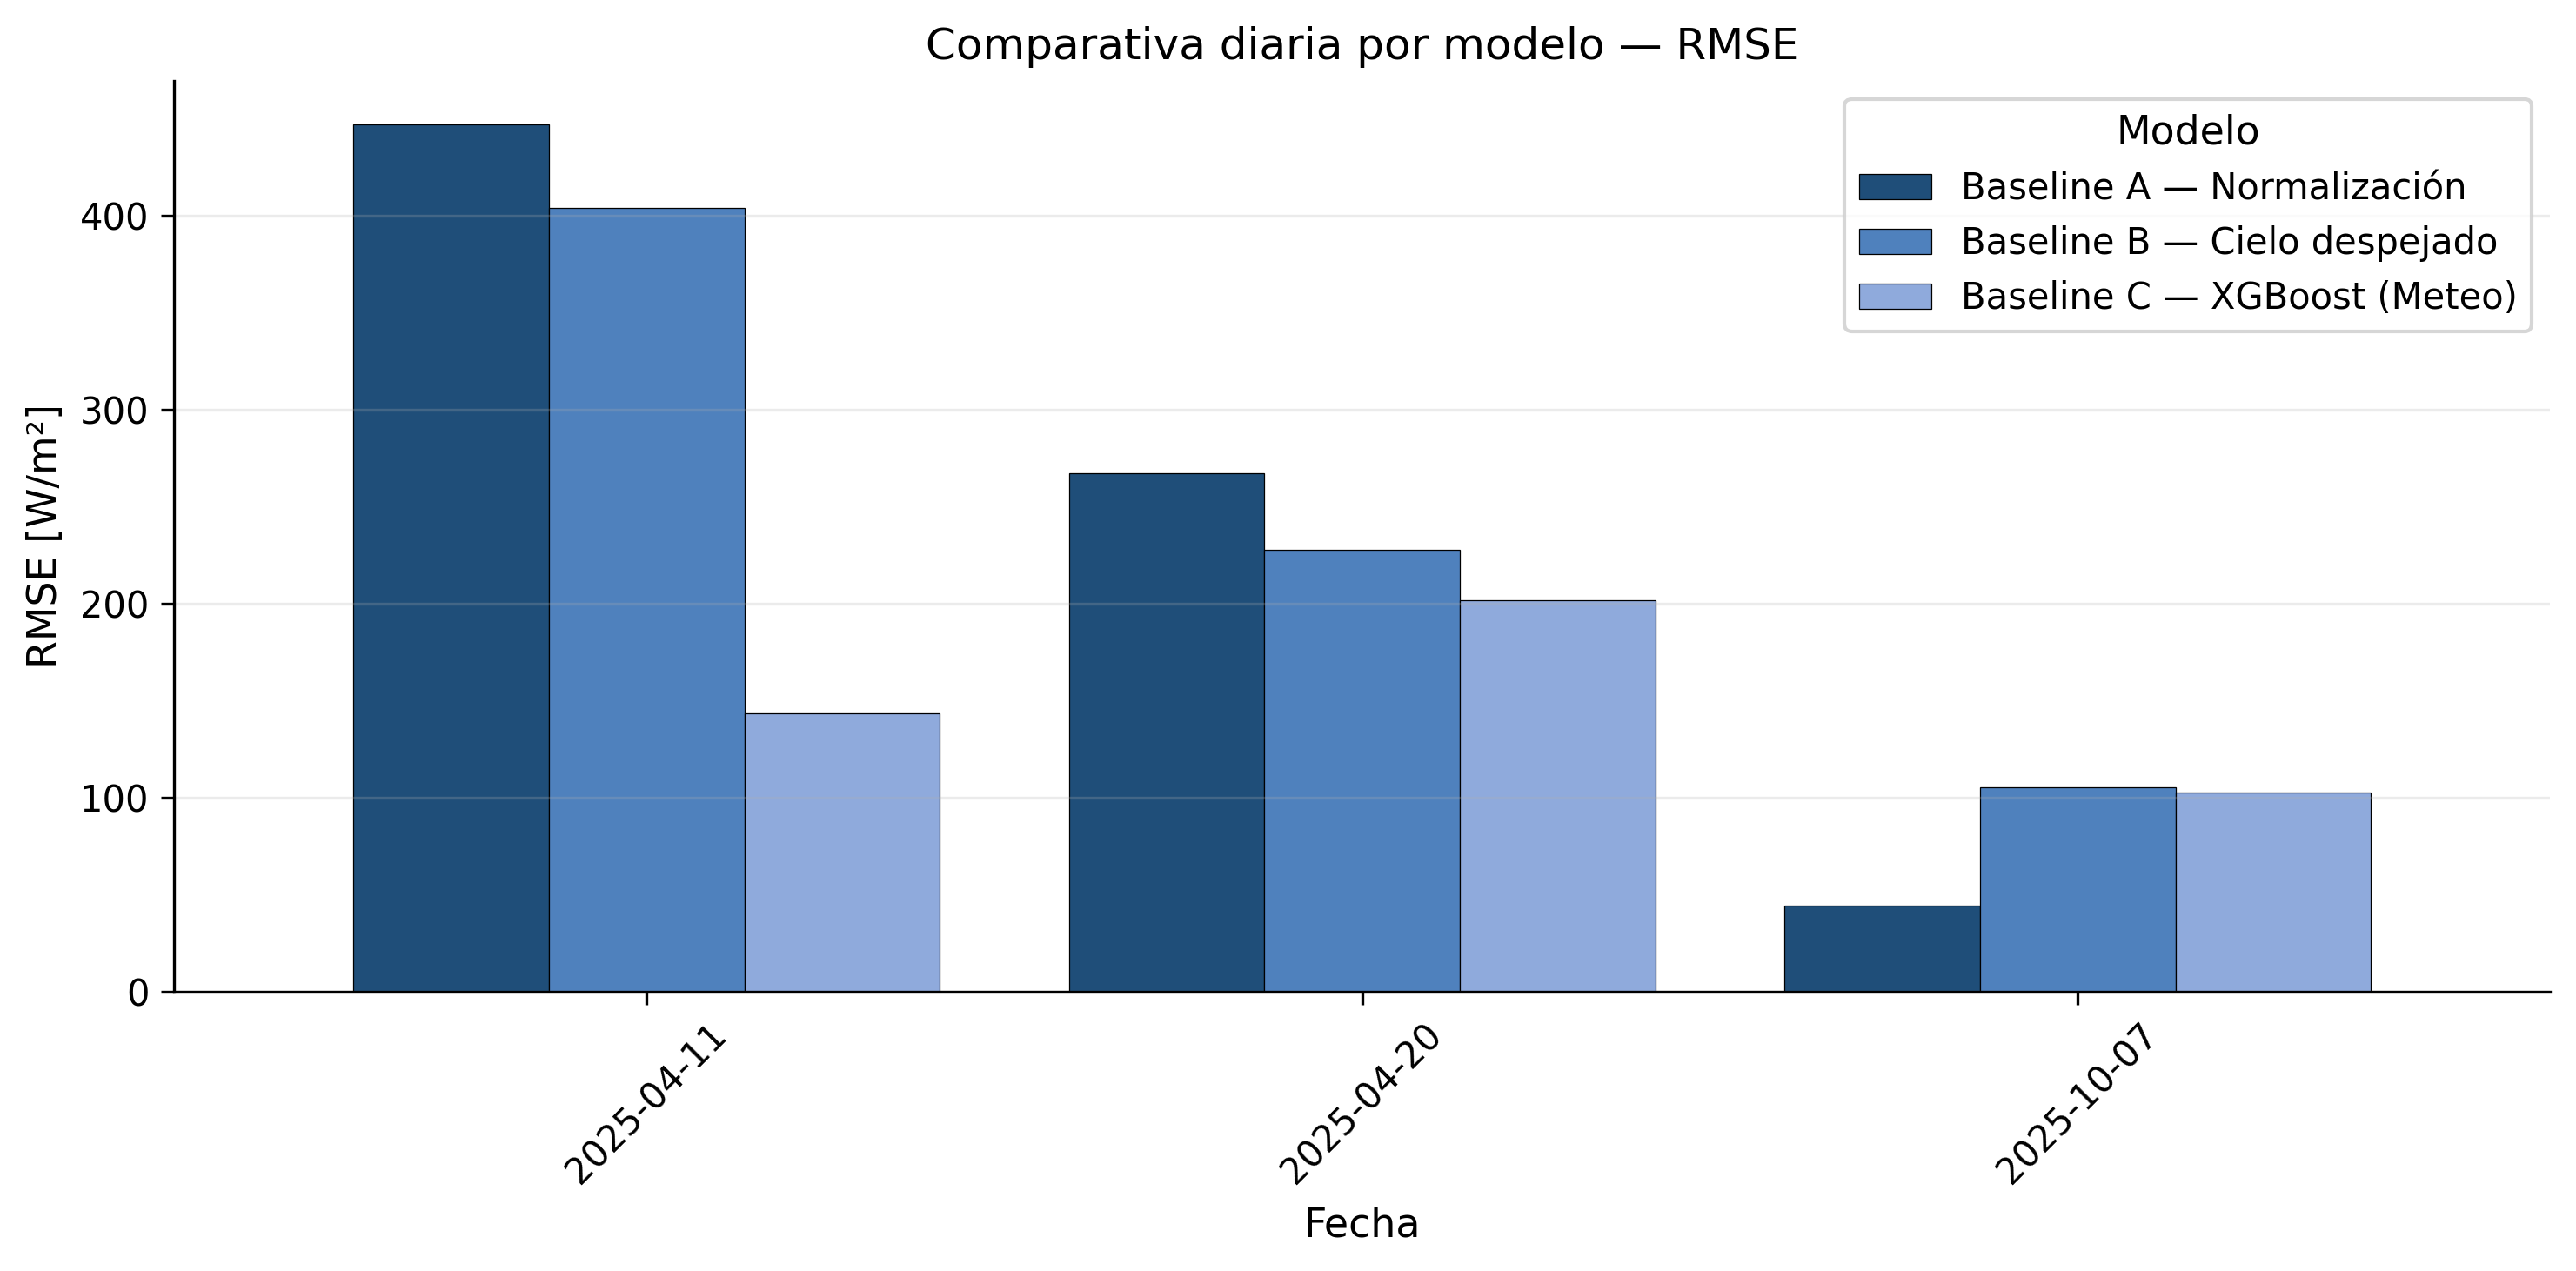

In [18]:
if __name__ == "__main__":
    df_summary, raw_results = run_baselines(CFG)

    # Global summary 
    print("\COMPARATIVA GLOBAL")
    cols_show = ["model", "global_r2", "global_rmse", "global_mae", "global_mbe"]
    print(df_summary[cols_show].round(3))

    # Daily tables (more detailed) + plot
    df_daily_metrics, pivots = print_daily_results(raw_results)

    # Plot daily RMSE comparison 
    if pivots is not None and "RMSE" in pivots:
        plot_daily_metric_bars(
            pivot=pivots["RMSE"],
            metric_name="RMSE",
            ylabel="RMSE [W/m²]",
            cfg=CFG,
            filename_base="comparativa_diaria_rmse",
            drop_mean=True
)